In [1]:
import numpy as np
import skimage.io as io
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# https://github.com/scikit-image/scikit-image/issues/140
# https://github.com/sciunto/scikit-image/blob/04bd238af18c32dede0eac4b52e51f8d4d91220c/skimage/transform/_polar.pyx
def cart2pol(img, center=None, full_output=False):
    """
    Polar transform of an image.

    Parameters
    ----------
    img : (M, N, D) ndarray
        Input image.
    center : (row, column) tuple or (2,) ndarray, optional
        Center of the polar transform.
        If None, the center is the center of the image.
    full_output : boolean, optional (default False)
        Extend the output to fully enclose the image.

    Returns
    -------
    polar : ndarray
        Polar transform.
    """
    angle = 360.0
    pi_over_180 = np.pi / 180.0
    imgshape0 = img.shape[0]
    imgshape1 = img.shape[1]

    # Default center.
    if not center:
        center0 = np.round(imgshape0/2.)
        center1 = np.round(imgshape1/2.)
    else:
        center0 = np.center[0]
        center1 = np.center[1]

    # Calculate the radius
    if full_output:
        # Pythagoras to find the largest radius
        deltax = max([center0, imgshape0 - center0])
        deltay = max([center1, imgshape1 - center1])
        radius = np.ceil(np.sqrt(deltax**2 + deltay**2))

        corner1 = radius - center1
        corner0 = radius - center0

        # Prepare a larger enclosing image
        if img.ndim == 2:
            extended_img = np.zeros((2*radius, 2*radius), dtype=img.dtype)
        elif img.ndim == 3:
            extended_img = np.zeros((2*radius, 2*radius, img.shape[2]),
                                    dtype=img.dtype)

        extended_img[corner1:corner1+imgshape1, corner0:corner0+imgshape0] = img
        img = extended_img
        del extended_img
        center0 = radius
        center1 = radius

    else:
        radius = min((center0,
                      center1,
                      imgshape0 - center0,
                      imgshape1 - center1))

    # Allocate an image
    if img.ndim == 2:
        img2 = np.zeros((radius, angle), dtype=img.dtype)
    elif img.ndim == 3:
        img2 = np.zeros((radius, angle, img.shape[2]), dtype=img.dtype)

    # convert to polar coordinates
    i = 0
    for a in np.arange(0,  angle, 1):
        a = a * pi_over_180
        j = 0
        sina = np.sin(a)
        cosa = np.cos(a)
        for r in np.arange(0, radius, 1):
            img2[j, i] = img[center1 + np.round(r*sina), center0 + np.round(r*cosa)]
            j += 1
        i += 1

    return img2

In [3]:
img_in = np.zeros((512,512), dtype=np.float32)
for i in np.arange(10,600,10):
    cv2.circle(img_in, (256,256), i - 9, np.random.rand(), thickness=4)

In [4]:
img_in.max()

0.99876845

(512, 512)

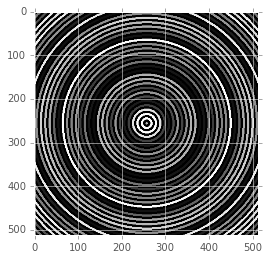

In [5]:
plt.imshow(img_in, cmap='gray')
img_in.shape

In [6]:
import cv2

In [13]:
img2 = cv2.linearPolar(img_in, (256, 256), 100, cv2.WARP_FILL_OUTLIERS)

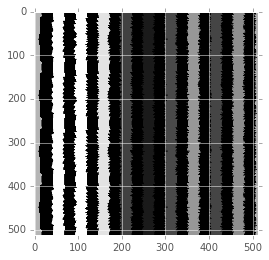

In [14]:
plt.imshow(img2, cmap='gray')

In [15]:
img3 = cv2.linearPolar(img2, (256, 256), 100, cv2.WARP_INVERSE_MAP + cv2.WARP_FILL_OUTLIERS)

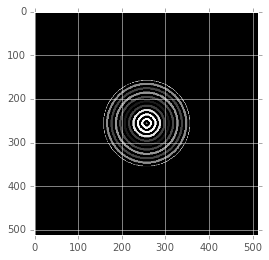

In [16]:
plt.imshow(img3, cmap='gray')

In [17]:
from pulse2percept import electrode2currentmap as e2cm

In [18]:
argus = e2cm.ArgusII(x_center=0, y_center=0)

In [38]:
# Create a retina
r_sampling = 100       # spatial sampling of retina
axon_lambda = 2        # constant that determines fall-off with axonal distance
rot = 0 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-3500, xhi=2500, ylo=-3000, yhi=3000)

In [20]:
xg_arr = np.linspace(e2cm.deg2micron(-15), e2cm.deg2micron(15), 100)
yg, xg = np.meshgrid(xg_arr, xg_arr)

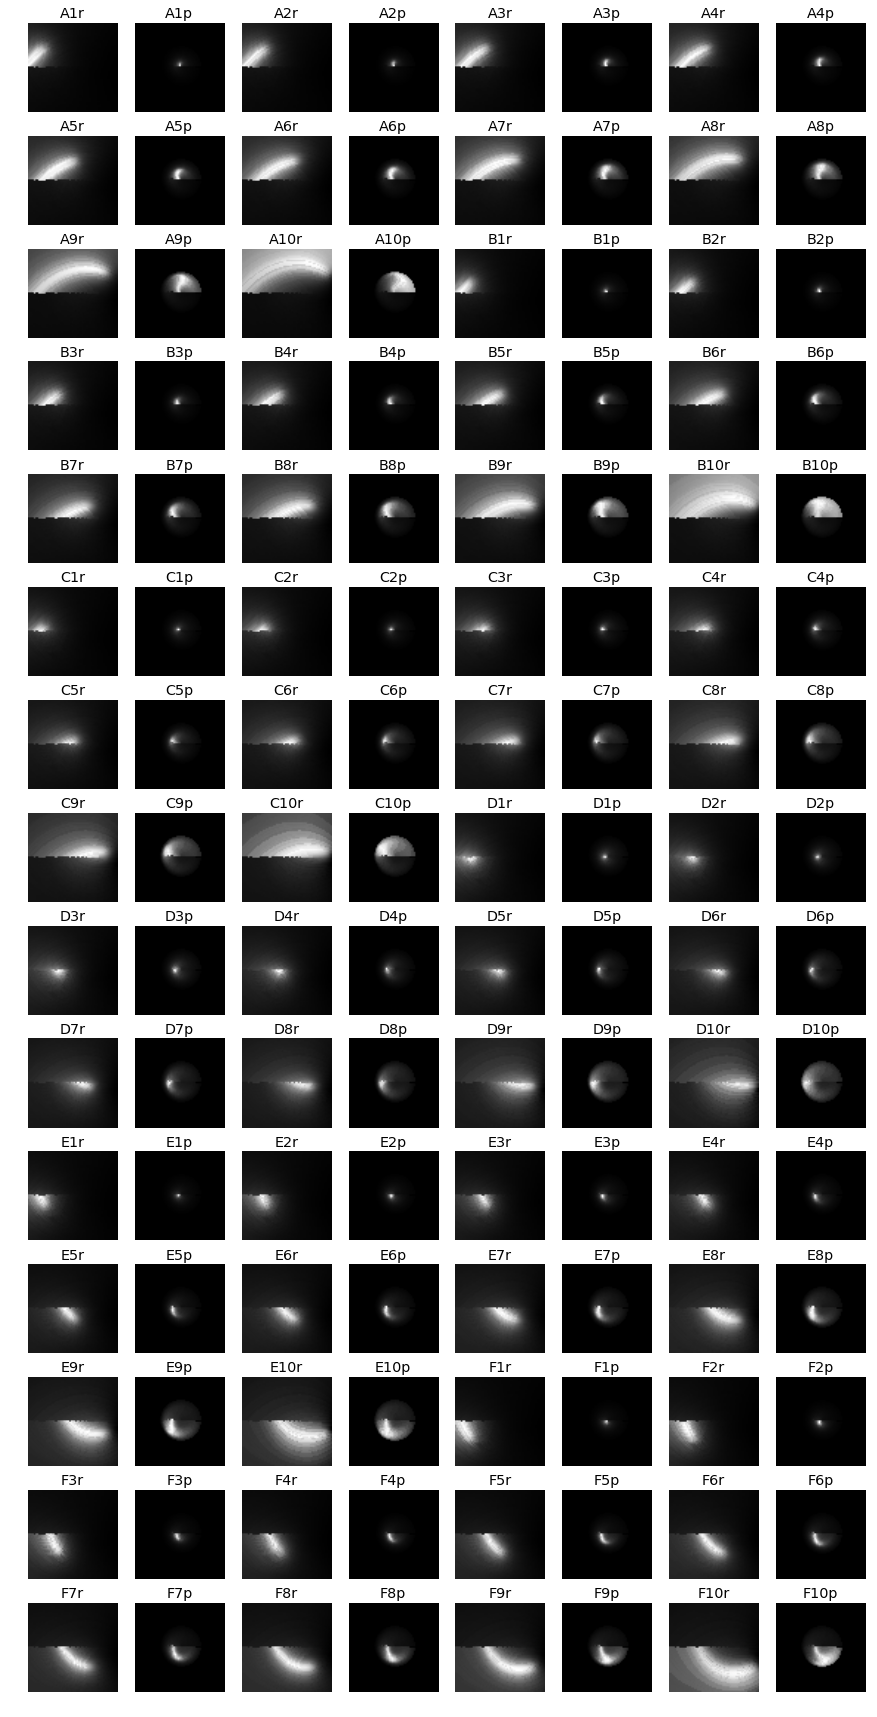

In [47]:
plt.figure(figsize=(15, 30))
for idx, e in enumerate(argus):
    plt.subplot(np.ceil(argus.num_electrodes / 4), 8, idx*2 + 1)
    cs = retina.cm2ecm(e.current_spread(retina.gridx, retina.gridy, 'NFL'))
    
    # no stim in the foveola
    for i, x in enumerate(retina.gridx[0]):
        for j, y in enumerate(retina.gridy[0]):
            if np.sqrt(x**2 + y**2) < 300.0 / 2.0:
                cs[i, j] = 0
        
    plt.imshow(cs, cmap='gray')
    plt.grid('off')
    plt.axis('off')
    plt.title(e.name + 'r')
    
    plt.subplot(np.ceil(argus.num_electrodes / 4), 8, (idx + 1) * 2)
    cs2 = cv2.linearPolar(cs, (cs.shape[0]/2, cs.shape[1]/2), 1500.0 / r_sampling, cv2.WARP_INVERSE_MAP + cv2.WARP_FILL_OUTLIERS)
    plt.imshow(np.flipud(cs2), cmap='gray')
    plt.grid('off')
    plt.axis('off')
    plt.title(e.name + 'p')
    plt.savefig('linearpolar.png')
